In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df

,account_id,amount,balance
date,,,
1993-01-01,2378,700.0,700.0
1993-01-01,576,900.0,900.0
1993-01-01,704,1000.0,1000.0
1993-01-01,3818,600.0,600.0
1993-01-02,1972,400.0,400.0
...,...,...,...
1998-12-31,2906,62.3,13729.4
1998-12-31,2935,81.3,19544.9
1998-12-31,2869,60.2,14638.2


In [3]:
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']
df

,Value
date,
1993-01,7.021576e+05
1993-02,2.726925e+06
1993-03,4.730319e+06
1993-04,7.378368e+06
1993-05,1.168075e+07
...,...
1998-08,1.506393e+08
1998-09,1.482977e+08
1998-10,1.518896e+08


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [22]:
def AR(p, df):
    df_temp = df

    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    print(f"df\n{df}")
    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    
    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    print(f'X_train \n {X_train}')
    print(f'y_ttain \n {y_train}')
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    print(f"The RMSE is : {RMSE} \tValue of p : {p}")
    return df_train_2,df_test,theta,intercept,RMSE

In [6]:
def MA(q, res):
    
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

In [7]:
def adf_check(time_series):
    """
    Pass in a time series, return ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test')
    
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

# Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [8]:
df.Value

date
1993-01    7.021576e+05
1993-02    2.726925e+06
1993-03    4.730319e+06
1993-04    7.378368e+06
1993-05    1.168075e+07
               ...     
1998-08    1.506393e+08
1998-09    1.482977e+08
1998-10    1.518896e+08
1998-11    1.488421e+08
1998-12    1.716971e+08
Name: Value, Length: 72, dtype: float64

In [9]:
np.log(df.Value)

date
1993-01    13.461913
1993-02    14.818685
1993-03    15.369503
1993-04    15.814063
1993-05    16.273453
             ...    
1998-08    18.830399
1998-09    18.814732
1998-10    18.838665
1998-11    18.818397
1998-12    18.961242
Name: Value, Length: 72, dtype: float64

In [10]:
pd.DataFrame(np.log(df.Value)).diff()

,Value
date,
1993-01,NaN
1993-02,1.356772
1993-03,0.550818
1993-04,0.444560
1993-05,0.459390
...,...
1998-08,0.022165
1998-09,-0.015667
1998-10,0.023932


In [11]:
df_testing = pd.DataFrame(np.log(df.Value)).diff().diff(12)

In [12]:
df_testing

,Value
date,
1993-01,NaN
1993-02,NaN
1993-03,NaN
1993-04,NaN
1993-05,NaN
...,...
1998-08,-0.000988
1998-09,-0.051039
1998-10,-0.000599


In [13]:
len(df_testing)

72

In [14]:
df_testing.Value.dropna()

date
1994-02   -1.665408
1994-03   -0.372616
1994-04   -0.441680
1994-05   -0.352188
1994-06   -0.090902
1994-07   -0.325125
1994-08   -0.128964
1994-09   -0.043756
1994-10   -0.159458
1994-11   -0.013330
1994-12   -0.080443
1995-01    0.010299
1995-02   -0.075272
1995-03    0.003420
1995-04    0.010533
1995-05   -0.018771
1995-06   -0.048559
1995-07    0.031722
1995-08    0.006699
1995-09   -0.046543
1995-10    0.051753
1995-11   -0.007981
1995-12   -0.009431
1996-01    0.006633
1996-02    0.059277
1996-03   -0.052947
1996-04    0.014948
1996-05   -0.017476
1996-06    0.024993
1996-07    0.039780
1996-08    0.027171
1996-09    0.027952
1996-10   -0.006265
1996-11    0.007103
1996-12    0.013637
1997-01   -0.017329
1997-02   -0.025826
1997-03    0.010147
1997-04   -0.007147
1997-05   -0.014150
1997-06   -0.010533
1997-07   -0.041084
1997-08   -0.036091
1997-09   -0.010777
1997-10   -0.023871
1997-11   -0.028481
1997-12   -0.016540
1998-01   -0.010479
1998-02   -0.049600
1998-03    0.00

In [15]:
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -5.225226609716361
p-value : 7.807176920051058e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


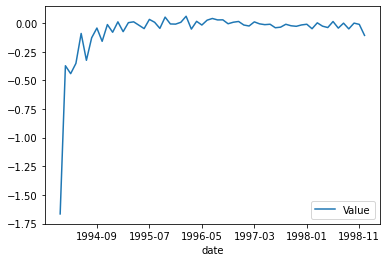

In [16]:
df_testing.plot()

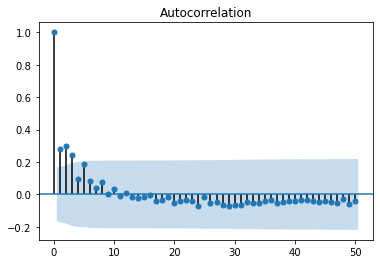

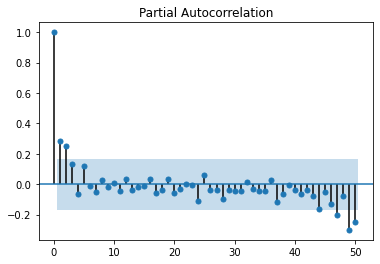

In [17]:
lags = 50
alpha = 0.2
ACF = plot_acf(df_testing.dropna(),lags=lags, alpha=alpha)
PACF = plot_pacf(df_testing.dropna(),lags=lags, alpha=alpha)

# Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [21]:
pd.DataFrame(df_testing.Value)

,Value
date,
1993-01,NaN
1993-02,NaN
1993-03,NaN
1993-04,NaN
1993-05,NaN
...,...
1998-08,-0.000988
1998-09,-0.051039
1998-10,-0.000599


In [23]:
best_RMSE = 1e15
best_p = -1

for i in range(1, 21):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(df_testing.Value))
    
    print(f'AR({i})\nRMSE:\t{RMSE}')
    
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

df
            Value  Shifted_values_1
date                               
1993-01       NaN               NaN
1993-02       NaN               NaN
1993-03       NaN               NaN
1993-04       NaN               NaN
1993-05       NaN               NaN
...           ...               ...
1998-08 -0.000988         -0.044303
1998-09 -0.051039         -0.000988
1998-10 -0.000599         -0.051039
1998-11 -0.011625         -0.000599
1998-12 -0.107750         -0.011625

[72 rows x 2 columns]
X_train 
 [[-1.6654083 ]
 [-0.37261604]
 [-0.44167996]
 [-0.35218806]
 [-0.09090185]
 [-0.32512509]
 [-0.12896441]
 [-0.04375551]
 [-0.15945797]
 [-0.01333044]
 [-0.08044346]
 [ 0.01029862]
 [-0.07527228]
 [ 0.00342034]
 [ 0.01053305]
 [-0.018771  ]
 [-0.04855905]
 [ 0.03172226]
 [ 0.00669896]
 [-0.04654324]
 [ 0.05175271]
 [-0.00798085]
 [-0.00943108]
 [ 0.00663338]
 [ 0.05927748]
 [-0.05294684]
 [ 0.01494809]
 [-0.01747613]
 [ 0.0249929 ]
 [ 0.03977975]
 [ 0.02717063]
 [ 0.02795212]
 [-0.00626545]
 

df
            Value  Shifted_values_1  Shifted_values_2  Shifted_values_3  \
date                                                                      
1993-01       NaN               NaN               NaN               NaN   
1993-02       NaN               NaN               NaN               NaN   
1993-03       NaN               NaN               NaN               NaN   
1993-04       NaN               NaN               NaN               NaN   
1993-05       NaN               NaN               NaN               NaN   
...           ...               ...               ...               ...   
1998-08 -0.000988         -0.044303          0.013255         -0.039227   
1998-09 -0.051039         -0.000988         -0.044303          0.013255   
1998-10 -0.000599         -0.051039         -0.000988         -0.044303   
1998-11 -0.011625         -0.000599         -0.051039         -0.000988   
1998-12 -0.107750         -0.011625         -0.000599         -0.051039   

         Shifted_valu

In [24]:
df_train,df_test,theta,intercept,RMSE = AR(best_p,pd.DataFrame(df_testing.Value))

df
            Value  Shifted_values_1  Shifted_values_2  Shifted_values_3  \
date                                                                      
1993-01       NaN               NaN               NaN               NaN   
1993-02       NaN               NaN               NaN               NaN   
1993-03       NaN               NaN               NaN               NaN   
1993-04       NaN               NaN               NaN               NaN   
1993-05       NaN               NaN               NaN               NaN   
...           ...               ...               ...               ...   
1998-08 -0.000988         -0.044303          0.013255         -0.039227   
1998-09 -0.051039         -0.000988         -0.044303          0.013255   
1998-10 -0.000599         -0.051039         -0.000988         -0.044303   
1998-11 -0.011625         -0.000599         -0.051039         -0.000988   
1998-12 -0.107750         -0.011625         -0.000599         -0.051039   

         Shifted_valu

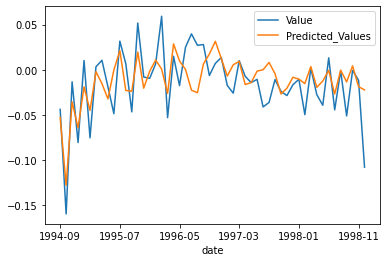

In [25]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

In [26]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [27]:
res

,Residuals
date,
1994-09,0.009048
1994-10,-0.031686
1994-11,0.022175
1994-12,-0.016185
1995-01,0.029131
1995-02,-0.030341
1995-03,0.005497
1995-04,0.025826
1995-05,0.013401


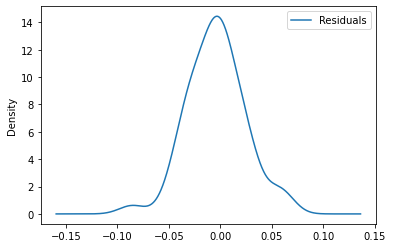

In [23]:
res.plot(kind='kde')

In [28]:
res.Residuals

date
1994-09    0.009048
1994-10   -0.031686
1994-11    0.022175
1994-12   -0.016185
1995-01    0.029131
1995-02   -0.030341
1995-03    0.005497
1995-04    0.025826
1995-05    0.013401
1995-06   -0.048368
1995-07    0.010466
1995-08    0.029627
1995-09   -0.022863
1995-10    0.032126
1995-11    0.012331
1995-12   -0.007849
1996-01   -0.004215
1996-02    0.058491
1996-03   -0.026815
1996-04   -0.013742
1996-05   -0.027224
1996-06    0.024599
1996-07    0.062319
1996-08    0.052512
1996-09    0.021583
1996-10   -0.023729
1996-11   -0.024460
1996-12    0.001223
1997-01   -0.010390
1997-02   -0.031426
1997-03    0.000789
1997-04    0.009149
1997-05   -0.000079
1997-06   -0.009066
1997-07   -0.041163
1997-08   -0.044275
1997-09   -0.006419
1997-10    0.002921
1997-11   -0.008178
1997-12   -0.008276
1998-01   -0.000177
1998-02   -0.034404
1998-03   -0.001781
1998-04   -0.008043
1998-05   -0.026820
1998-06    0.013818
1998-07   -0.017525
1998-08   -0.000614
1998-09   -0.037664
1998-10   -0.00

The RMSE is : 0.03198402156567749 , Value of q :  1
The RMSE is : 0.032989430227765876 , Value of q :  2
The RMSE is : 0.03408338236742453 , Value of q :  3
The RMSE is : 0.03450430781256751 , Value of q :  4
The RMSE is : 0.03535131908637555 , Value of q :  5
The RMSE is : 0.03586708191143001 , Value of q :  6
The RMSE is : 0.03718574869751802 , Value of q :  7
The RMSE is : 0.037286951086643504 , Value of q :  8
The RMSE is : 0.03807875111483282 , Value of q :  9
The RMSE is : 0.03736485660629248 , Value of q :  10
The RMSE is : 0.037903042892427484 , Value of q :  11
The RMSE is : 0.04337445915271735 , Value of q :  12


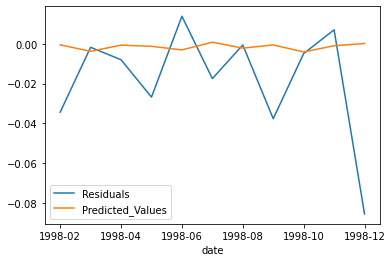

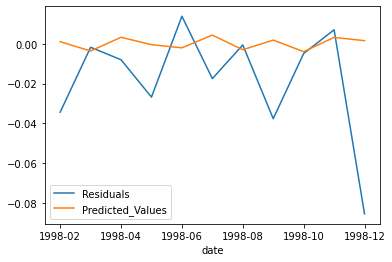

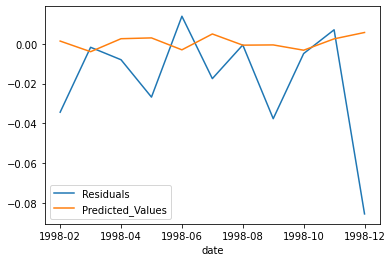

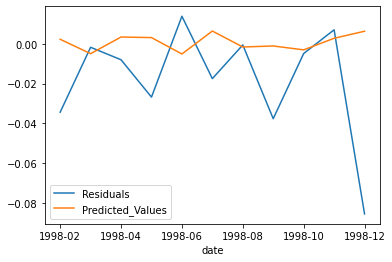

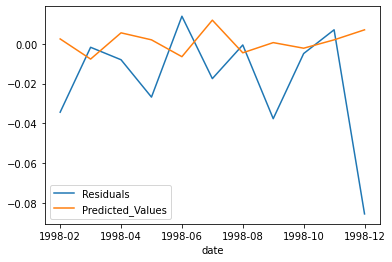

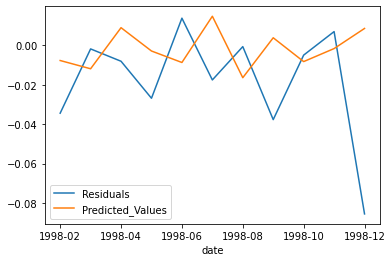

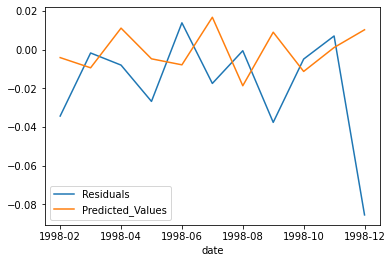

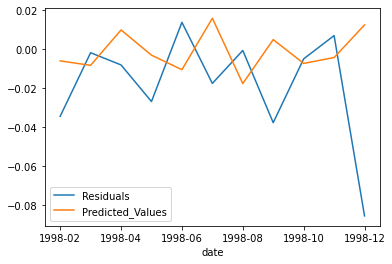

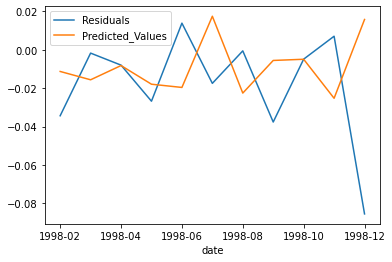

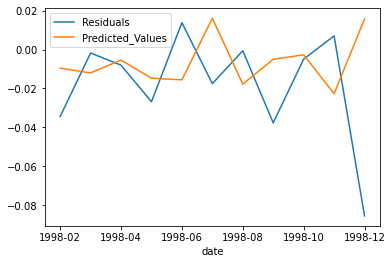

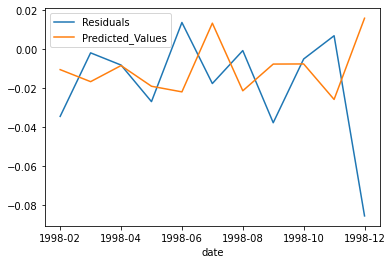

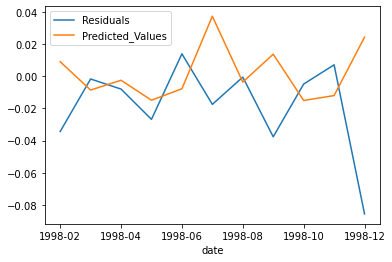

In [29]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    
    if(RMSE<best_RMSE):
      best_RMSE = RMSE
      best_q = i

In [26]:
print(f'best_q:\t {best_q}')

best_q:	 1


The RMSE is : 0.03198402156567749 , Value of q :  1
theta: [[0.09510917]]
intercept: [-0.00053678]


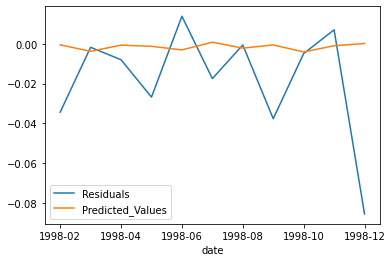

In [27]:
res_train,res_test,theta,intercept,RMSE = MA(best_q,pd.DataFrame(res.Residuals))
print(f'theta: {theta}')
print(f'intercept: {intercept}')

In [28]:
res_c = pd.concat([res_train,res_test])
res_c

,Residuals,Shifted_values_1,Predicted_Values
date,,,
1994-10,-0.031686,0.009048,0.000324
1994-11,0.022175,-0.031686,-0.003550
1994-12,-0.016185,0.022175,0.001572
1995-01,0.029131,-0.016185,-0.002076
1995-02,-0.030341,0.029131,0.002234
1995-03,0.005497,-0.030341,-0.003422
1995-04,0.025826,0.005497,-0.000014
1995-05,0.013401,0.025826,0.001919
1995-06,-0.048368,0.013401,0.000738


In [29]:
df_c.Predicted_Values += res_c.Predicted_Values

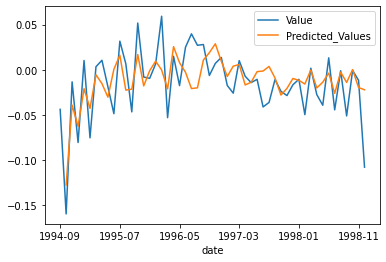

In [30]:
df_c[['Value','Predicted_Values']].plot()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [31]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
date,,,,,,,,,
1994-09,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-1.665408,NaN
1994-10,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-0.127448
1994-11,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.039056
1994-12,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.062686
1995-01,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.020908
1995-02,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.042698
1995-03,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.005499
1995-04,0.010533,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.015307
1995-05,-0.018771,0.010533,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.030253


In [32]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [33]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
date,,,,,,,,,
1994-09,4.647984e+07,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-1.665408,NaN
1994-10,4.661549e+07,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,4.813179e+07
1994-11,4.759123e+07,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,4.638252e+07
1994-12,6.190363e+07,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,6.301268e+07
1995-01,6.624558e+07,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,6.421018e+07
1995-02,4.512608e+07,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,4.662025e+07
1995-03,5.411343e+07,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,5.363294e+07
1995-04,5.484414e+07,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,-0.043756,5.344514e+07
1995-05,5.991497e+07,0.010533,0.003420,-0.075272,0.010299,-0.080443,-0.013330,-0.159458,5.923097e+07


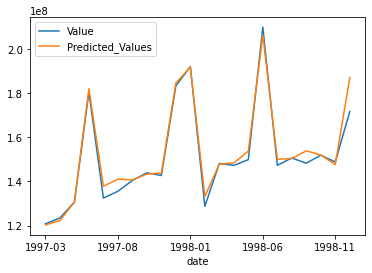

In [34]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()